Coexisting densities: phi1 = -1.0579, phi2 = 0.9298


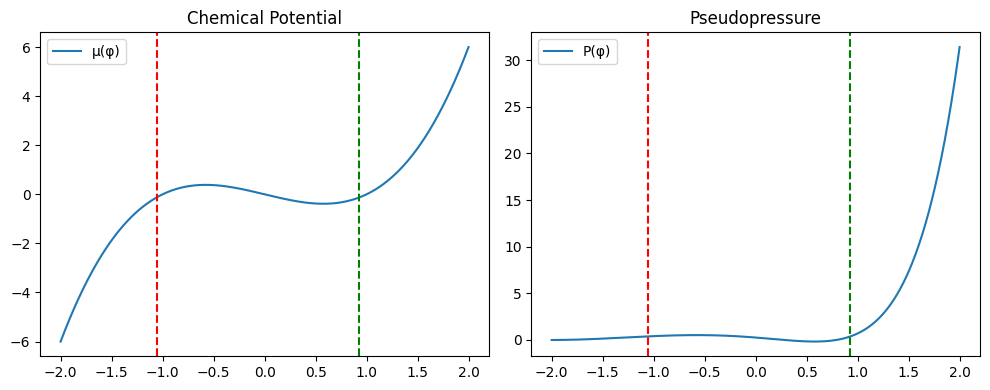

In [18]:
import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Model parameters
A = -1
B = 1
K = 1
zeta = -4   # Try a value like 1.0 or 2.0
lmbda = -2.5   # Lambda spelled out

alpha = (zeta - 2 * lmbda) / K

# Define phi grid
phi = np.linspace(-2, 2, 1000)

# Step 1: Pseudodensity psi(phi)
dpsi_dphi = np.exp(alpha * phi)
psi = cumulative_trapezoid(dpsi_dphi, phi, initial=0)

# Step 2: Pseudopotential g(phi)
f_prime = A * phi + B * phi**3
dg_dphi = f_prime * dpsi_dphi
g = cumulative_trapezoid(dg_dphi, phi, initial=0)

# Interpolators for numerical functions
from scipy.interpolate import interp1d
mu_interp = interp1d(phi, f_prime, kind='cubic')
psi_interp = interp1d(phi, psi, kind='cubic')
g_interp = interp1d(phi, g, kind='cubic')
P_interp = lambda x: psi_interp(x) * mu_interp(x) - g_interp(x)

# Step 3: Solve for phi1 and phi2
def coexistence_system(vars):
    phi1, phi2 = vars
    return [
        mu_interp(phi1) - mu_interp(phi2),
        P_interp(phi1) - P_interp(phi2)
    ]

phi_guess = [-1.0, 1.0]
phi1, phi2 = fsolve(coexistence_system, phi_guess)

print(f"Coexisting densities: phi1 = {phi1:.4f}, phi2 = {phi2:.4f}")

# Optional: Plot chemical potential and pseudopressure
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(phi, f_prime, label='μ(φ)')
plt.axvline(phi1, color='red', linestyle='--')
plt.axvline(phi2, color='green', linestyle='--')
plt.title('Chemical Potential')
plt.legend()

plt.subplot(1, 2, 2)
P_vals = P_interp(phi)
plt.plot(phi, P_vals, label='P(φ)')
plt.axvline(phi1, color='red', linestyle='--')
plt.axvline(phi2, color='green', linestyle='--')
plt.title('Pseudopressure')
plt.legend()

plt.tight_layout()
plt.show()


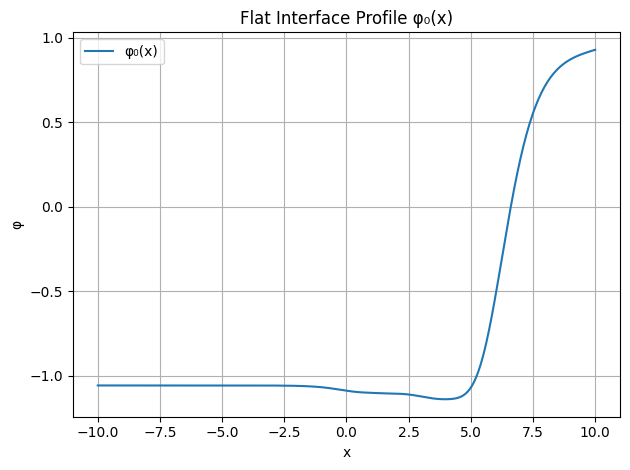

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Use your binodal values from Appendix B
phi1 = -1.0579
phi2 = 0.9298

# Model parameters
A = -1
B = 1
K = 1
mu = A * phi1 + B * phi1**3  # You can also average mu(phi1) and mu(phi2)

# Define the ODE: d²φ/dx² = (df/dφ - μ) / K
def ode(x, y):
    phi = y[0]
    dphi_dx = y[1]
    df_dphi = A * phi + B * phi**3
    d2phi_dx2 = (df_dphi - mu) / K
    return np.vstack([dphi_dx, d2phi_dx2])

# Boundary conditions: phi at -L and +L
def bc(ya, yb):
    return np.array([ya[0] - phi1, yb[0] - phi2])

# Spatial domain
L = 10
x = np.linspace(-L, L, 500)
# Initial guess: tanh-like profile
phi_guess = phi1 + (phi2 - phi1) * (np.tanh(x) + 1)/2
y_guess = np.vstack([phi_guess, np.gradient(phi_guess, x)])

# Solve BVP
sol = solve_bvp(ode, bc, x, y_guess)

# Plot result
x_plot = sol.x
phi0 = sol.y[0]
dphi_dx = sol.y[1]

plt.plot(x_plot, phi0, label='φ₀(x)')
plt.xlabel("x")
plt.ylabel("φ")
plt.title("Flat Interface Profile φ₀(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
from scipy.integrate import simpson

# Extract profile and derivative from the BVP solution
x_vals = sol.x
phi_vals = sol.y[0]
dphi_dx_vals = sol.y[1]

# Compute S0 and S1
S0 = simpson(dphi_dx_vals**2, x_vals)
S1 = simpson(phi_vals * dphi_dx_vals**2, x_vals)

# Define activity parameters and compute sigma
zeta = -4     # same as in Step 1
lmbda = -2.5    # same as in Step 1
K = 1

denom = zeta - 2 * lmbda
if np.abs(denom) < 1e-6:
    raise ValueError("Denominator ζ − 2λ is too small, pseudotension is ill-defined.")

sigma = K / denom * (zeta * S0 - 2 * lmbda * S1)

print(f"S₀ = {S0:.6f}")
print(f"S₁ = {S1:.6f}")
print(f"Pseudotension σ = {sigma:.6f}")


S₀ = 1.236402
S₁ = -0.235561
Pseudotension σ = -6.123415


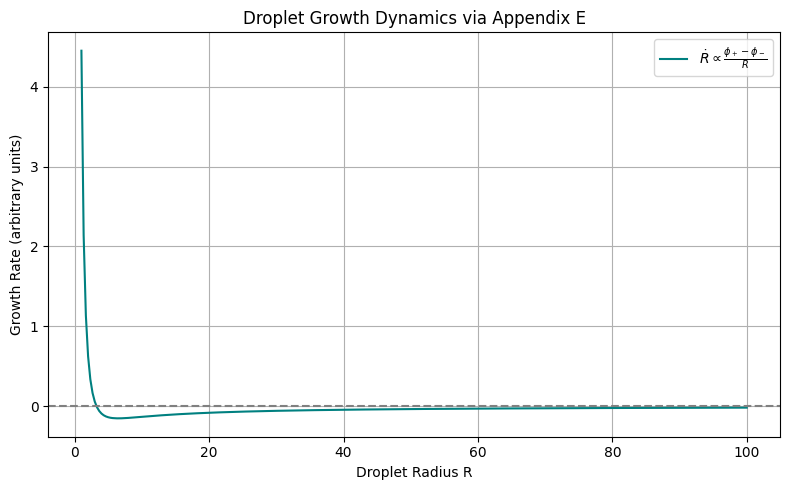

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# From earlier steps
phi1 = -1.0579
phi2 = 0.9298

A = -1
B = 1
sigma = -6.123415 # Your computed pseudotension

# Second derivatives of f at binodals
fpp_phi1 = A + 3 * B * phi1**2
fpp_phi2 = A + 3 * B * phi2**2

# Compute curvature correction coefficients
a_plus = -sigma / fpp_phi1
a_minus = sigma / fpp_phi2

# Radii range
R_vals = np.linspace(1, 100, 300)
phi_plus = phi1 + a_plus / R_vals
phi_minus = phi2 + a_minus / R_vals

# Growth rate (up to constant)
dR_dt = (phi_plus - phi_minus) / R_vals

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(R_vals, dR_dt, label=r"$\dot{R} \propto \frac{\phi_+ - \phi_-}{R}$", color='teal')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Droplet Radius R")
plt.ylabel("Growth Rate (arbitrary units)")
plt.title("Droplet Growth Dynamics via Appendix E")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
import numpy as np
from scipy.integrate import cumulative_trapezoid, solve_bvp, simpson
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

# Constants
A = -1
B = 1
K = 1
phi_grid = np.linspace(-2, 2, 1000)

# 1. Compute psi and g
def compute_psi_g(phi, alpha):
    dpsi_dphi = np.exp(alpha * phi)
    psi = cumulative_trapezoid(dpsi_dphi, phi, initial=0)
    f_prime = A * phi + B * phi**3
    dg_dphi = f_prime * dpsi_dphi
    g = cumulative_trapezoid(dg_dphi, phi, initial=0)
    return psi, g, f_prime

# 2. Interpolators and pseudopressure
def build_interpolators(phi, psi, g, f_prime):
    mu_interp = interp1d(phi, f_prime, kind='cubic', fill_value='extrapolate')
    psi_interp = interp1d(phi, psi, kind='cubic', fill_value='extrapolate')
    g_interp = interp1d(phi, g, kind='cubic', fill_value='extrapolate')
    P_interp = lambda x: psi_interp(x) * mu_interp(x) - g_interp(x)
    return mu_interp, P_interp

# 3. Solve for binodals
def solve_binodals(mu_interp, P_interp):
    def coexistence(vars):
        phi1, phi2 = vars
        return [mu_interp(phi1) - mu_interp(phi2), P_interp(phi1) - P_interp(phi2)]
    phi_init = [-1.0, 1.0]
    return fsolve(coexistence, phi_init)

# 4. Solve interface profile via BVP
def solve_interface_profile(phi1, phi2):
    mu = A * phi1 + B * phi1**3
    def ode(x, y):
        phi, dphi = y
        d2phi = (A * phi + B * phi**3 - mu) / K
        return np.vstack([dphi, d2phi])
    def bc(ya, yb):
        return np.array([ya[0] - phi1, yb[0] - phi2])
    x = np.linspace(-10, 10, 500)
    guess = phi1 + (phi2 - phi1) * (np.tanh(x) + 1)/2
    y_guess = np.vstack([guess, np.gradient(guess, x)])
    return solve_bvp(ode, bc, x, y_guess)

# 5. Compute sigma
def compute_sigma(sol, zeta, lmbda):
    x_vals = sol.x
    phi_vals = sol.y[0]
    dphi_dx = sol.y[1]
    S0 = simpson(dphi_dx**2, x_vals)
    S1 = simpson(phi_vals * dphi_dx**2, x_vals)
    denom = zeta - 2 * lmbda
    if np.abs(denom) < 1e-6:
        return np.nan  # ill-defined tension
    return K / denom * (zeta * S0 - 2 * lmbda * S1)


In [27]:
zeta_range = np.linspace(-4, 4, 20)
lambda_range = np.linspace(-2, 2, 20)
phi_results = []
sigma_results = []

for zeta in zeta_range:
    for lmbda in lambda_range:
        try:
            alpha = (zeta - 2 * lmbda) / K
            psi, g, f_prime = compute_psi_g(phi_grid, alpha)
            mu_interp, P_interp = build_interpolators(phi_grid, psi, g, f_prime)
            phi1, phi2 = solve_binodals(mu_interp, P_interp)
            sol = solve_interface_profile(phi1, phi2)
            sigma = compute_sigma(sol, zeta, lmbda)
            phi_results.append((zeta, lmbda, phi1, phi2))
            sigma_results.append((zeta, lmbda, sigma))
        except Exception as e:
            print(f" Error for zeta={zeta}, lambda={lmbda}: {e}")


C:\Users\anuhe\AppData\Local\Temp\ipykernel_32332\587072854.py:35: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  return fsolve(coexistence, phi_init)
C:\Users\anuhe\AppData\Local\Temp\ipykernel_32332\587072854.py:35: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(coexistence, phi_init)


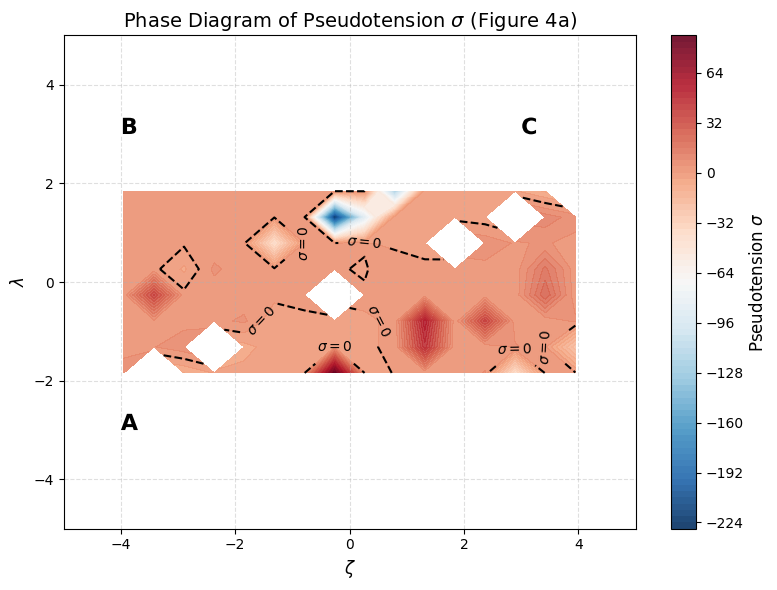

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# Assume these match your zeta_range and lambda_range
zeta_range = np.linspace(-5, 5, 20)
lambda_range = np.linspace(-5, 5, 20)

# Convert sigma_results list to structured arrays
sigma_array = np.full((len(zeta_range), len(lambda_range)), np.nan)

for zeta, lmbda, sigma in sigma_results:
    i = np.argmin(np.abs(zeta_range - zeta))
    j = np.argmin(np.abs(lambda_range - lmbda))
    sigma_array[i, j] = sigma

Z, L = np.meshgrid(zeta_range, lambda_range, indexing='ij')

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.contourf(Z, L, sigma_array, levels=100, cmap='RdBu_r', alpha=0.9)
cbar = fig.colorbar(c)
cbar.set_label(r"Pseudotension $\sigma$", fontsize=12)

# Zero contour: phase boundary
contours = ax.contour(Z, L, sigma_array, levels=[0], colors='black', linewidths=1.5, linestyles='--')
ax.clabel(contours, fmt={0: r'$\sigma = 0$'}, inline=True, fontsize=10)

# Optional: label regions
ax.text(-4, -3, 'A', fontsize=16, weight='bold', color='black',
        path_effects=[pe.withStroke(linewidth=3, foreground='white')])
ax.text(3, 3, 'C', fontsize=16, weight='bold', color='black',
        path_effects=[pe.withStroke(linewidth=3, foreground='white')])
ax.text(-4, 3, 'B', fontsize=16, weight='bold', color='black',
        path_effects=[pe.withStroke(linewidth=3, foreground='white')])

ax.set_xlabel(r"$\zeta$", fontsize=12)
ax.set_ylabel(r"$\lambda$", fontsize=12)
ax.set_title("Phase Diagram of Pseudotension $\sigma$ (Figure 4a)", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
